In [87]:
import json
import os
import random

import cv2
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm

from model import Model

In [88]:
print("Loading dataset...")
ROLES = set()
role_pad_idx = 0

data_folder = "data/"
files = []
for file in tqdm(os.listdir(data_folder)):
    json_path = os.path.join(data_folder, file)
    files.append(json_path)

    with open(json_path, "r") as f:
        data = json.load(f)

    for node in data["nodes"]:
        ROLES.add(node["role"])
ROLES = ["<PAD_TOKEN>"] + sorted(list(ROLES))

# split train val
random.seed(42)
random.shuffle(files)
train_files = files[: int(len(files) * 0.8)]
val_files = files[int(len(files) * 0.8) :]

Loading dataset...


100%|██████████| 4866/4866 [00:00<00:00, 10504.20it/s]


In [106]:
import safetensors

model = Model(
    hidden_channels=[64, 64, 64, 64],
    graph_in=256,
    graph_out=256,
    hidden_dim=256,
    dropout=0,
    num_roles=len(ROLES),
    role_pad_idx=role_pad_idx,
)

weights_path = "/home/thanh/experiments/gcn/assessment_2/outputs/model.safetensors"
model.load_state_dict(safetensors.torch.load_file(weights_path))
model.eval()

Model(
  (role_embedding): Embedding(93, 16, padding_idx=0)
  (layout_embedding): Embedding(1281, 16)
  (linear): Linear(in_features=80, out_features=256, bias=True)
  (convs): ModuleList(
    (0): SAGEConv(256, 64, aggr=mean)
    (1-3): 3 x SAGEConv(64, 64, aggr=mean)
    (4): SAGEConv(64, 256, aggr=mean)
  )
  (dense): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)

pred box [960  60 250 108]
target box [960  60 250 108]


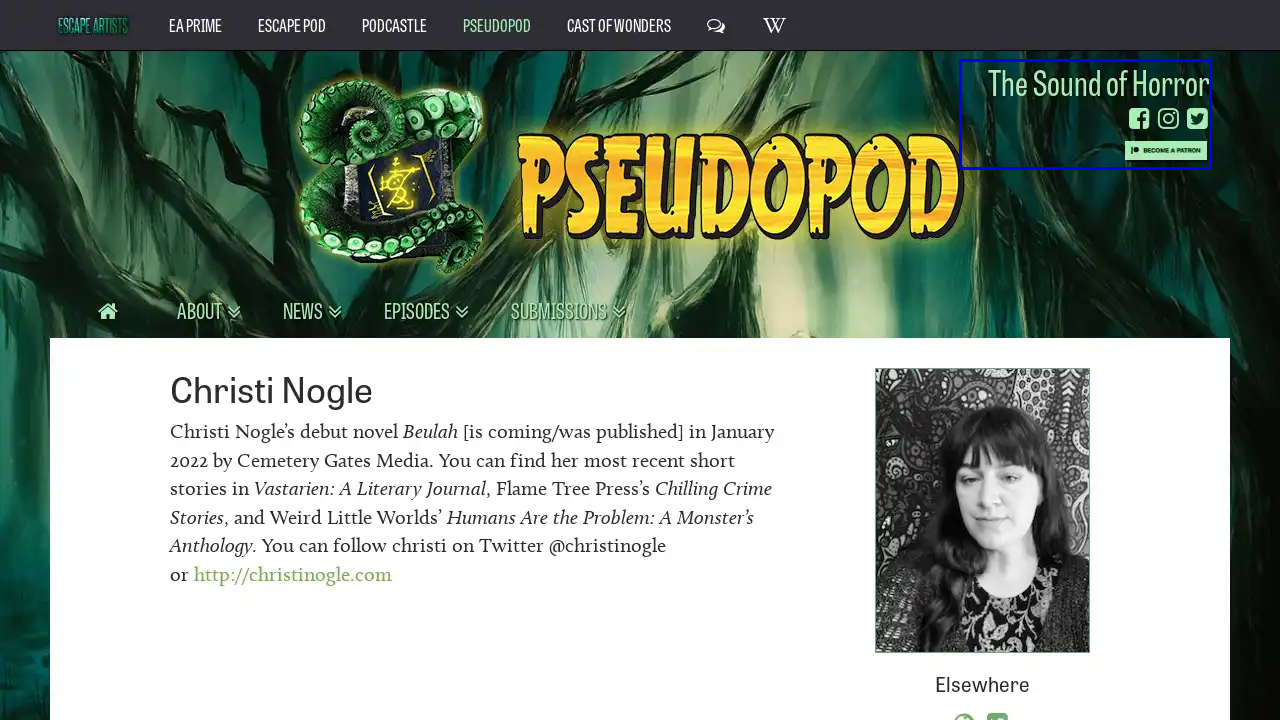

In [212]:
# example = "data/1656346041146.json"
# example = "data/1656381776700.json"
# example = 'data/1655907083460.json'
example = random.choice(val_files)

def predict(example):
    with open(example, "r") as f:
        data = json.load(f)

    image_path = data["image_path"]
    nodes = data["nodes"]

    node_id_to_idx = {node["id"]: i for i, node in enumerate(nodes)}
    edges = data["edges"]
    edge_index = np.array(
        [
            [node_id_to_idx[e[0]], node_id_to_idx[e[1]]]
            for e in edges
            if e[0] in node_id_to_idx and e[1] in node_id_to_idx
        ]
    )

    boxes = np.array([node["box"] for node in nodes]).astype(np.int64)
    boxes[boxes < 0] = 0
    # remove larger value than max image size
    boxes[boxes[:, 0] > 1280, 0] = 1280
    boxes[boxes[:, 1] > 720, 1] = 720
    boxes[boxes[:, 2] > 1280, 2] = 1280
    boxes[boxes[:, 3] > 720, 3] = 720

    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]  # width
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]  # height

    layout_feat = torch.tensor(boxes, dtype=torch.long)

    roles = [ROLES.index(node["role"]) for node in nodes]
    role_feat = torch.tensor(roles, dtype=torch.long)

    edge_index = torch.tensor(np.swapaxes(edge_index, 0, 1).astype(np.int64))

    target = [node["is_absolute"] for node in nodes]
    # set target = 0 for those node that has h = 0 or w = 0
    for i, (t, box) in enumerate(zip(target, boxes)):
        if box[2] == 0 or box[3] == 0:
            target[i] = 0

    target = torch.tensor(target, dtype=torch.long)

    output = model(
        x_layout=torch.stack([layout_feat]),
        x_role=torch.stack([role_feat]),
        edge_index=edge_index,
    )[0]
    predictions = torch.softmax(output, dim=-1)
    predictions = predictions.cpu().detach().numpy()

    predictions = np.argmax(predictions, axis=1)
    
    return image_path, predictions, boxes, target


image_path, predictions, boxes, targets = predict(example)

# visualize box
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
for box, pred, target in zip(boxes, predictions, targets):
    box = box.astype(np.int64)
    if pred == 1:
        print("pred box", box)
        color = (0, 255, 0)
        cv2.rectangle(image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), color, 2)
        
    if target == 1:
        print("target box", box)
        color = (0, 0, 255)
        cv2.rectangle(image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), color, 2)
        
Image.fromarray(image)